# Lab. 8 Autoencoders

![Auto-encoder](utils/ae.png)


"Vanilla" autoenkodery minimalizują tzw. _reconstruction error_, najczęściej wyrażony w postaci błędu średniokwadratowego liczonego pomiędzy oryginalnym wejściem i rekonstrukcją.

<font size=4>
$$ \mathcal{L}(x, dec(enc(x))) = ||x - dec(enc(x))||^2 $$
</font>

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składam się z tych samych transformacji co enkoder w odwrtonej kolejności.  

**Pytanie:** Co mogłoby się stać gdybyśmy nie "zwężali" enkodera? 


In [0]:
def plot_digits(view_data, decoded_data=None):
    
    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())
        
        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())
    
    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    
    plt.show()

### Setup i dane

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt

import numpy as np


torch.manual_seed(1337) 
batch_size = 64 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:02, 4506708.15it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 67769.35it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1130142.47it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25439.97it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Zadanie 1: Vanilla Autoencoder

Zaimplementować Autoenkoder z 5 warstwami liniowymi (z nieliniową aktywacją np. `tanh`) w enkoderze: 
   * wejściowa (rozmiar cyfry z MNISTA)
   * rozmiaru 128
   * rozmiaru 64
   * rozmiaru 12
   * rozmiaru `latent_dim`
oraz dekoderem z dokładnie odwrotnym przekształceniem.
    
**Pytanie:** Jaka powinna być funkcja aktywacji na wyjściu dekodera? 

In [0]:
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )
        
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        code = self.encode(x)
        final = self.decode(code)
        return code, final


## Zadanie 2: Pętla Uczenia
Uzupełnić brakujące fragmenty kodu uczenia.

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Epoch:  0 | train loss: 0.1152


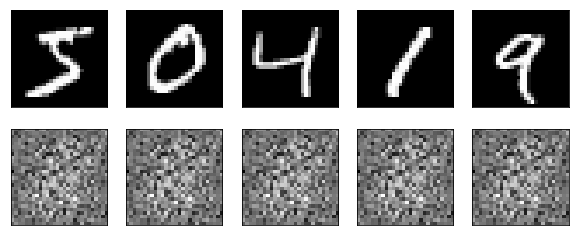

Epoch:  0 | train loss: 0.0446


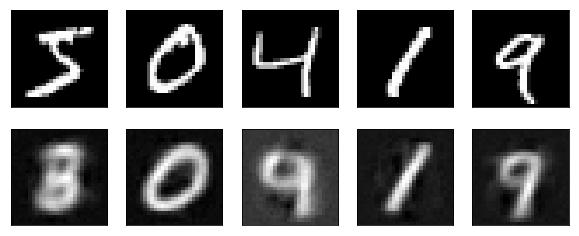

Epoch:  5 | train loss: 0.0360


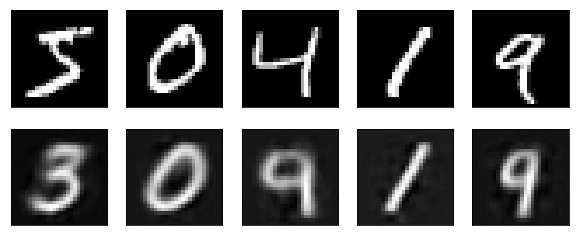

Epoch:  5 | train loss: 0.0334


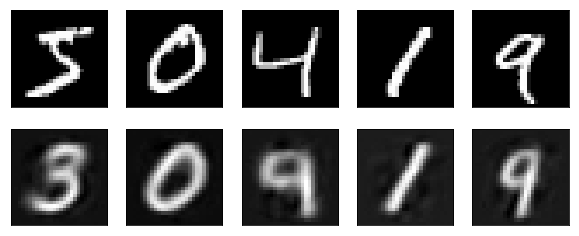

Epoch:  9 | train loss: 0.0367


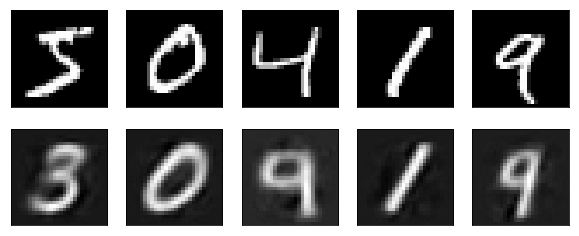

Epoch:  9 | train loss: 0.0337


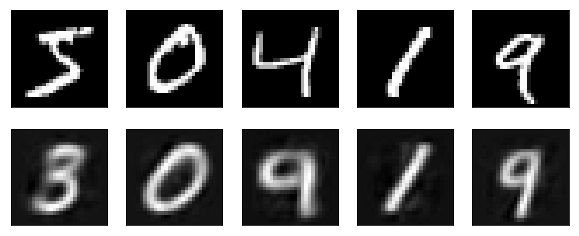

In [23]:
# Hyper Parameters
epochs = 10
lr = 0.005 
n_plots = 5

# prepare original data for plotting
view_data = train_data.train_data[:n_plots].view(-1, 28*28).type(torch.FloatTensor) / 255.

autoencoder = AutoEncoder(latent_dim=3)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = nn.MSELoss() # MSE loss function


for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):

        encoded, decoded = autoencoder(x)

        loss = loss_func(x, decoded) # calculate loss
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 500 == 0 and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            plot_digits(view_data, decoded_data)

# Zadanie 3: "Generowanie" z Autoenkodera

Teoretycznie nasz "vanilla" autoenkoder nie ma naturalnych właściwości generatywnych (więcej w przyszłości przy VAE), ale mimo to spróbujmy wygenerować z niego nowe przykłady.

1. Załóżmy, że nasz autoenkoder układa dane "w środku" w rozkład normalny. Waszym zadaniem jest oszacowanie średniej i wariancji tego rozkładu dla `n` przykładów ze zbioru trenującego. Należy to zrobić na podstawie części zbioru trenującego.

In [16]:
samples = []
n = 500

for step, (x, y) in enumerate(train_loader):
    
    if len(samples) > n:
        break
    
    # encode the points into the latent space and save for later estimation    
    enc, dec = autoencoder(x)
    samples.append(enc.detach().numpy())
    
    
samples_concatenated = np.concatenate(samples, axis=0)
# compute mean and std of the empirical distribution in the latent space 
tensor_samples = torch.FloatTensor(samples_concatenated)
mean_sampled = torch.mean(tensor_samples, 0)
std_sampled = torch.std(tensor_samples, 0)
print(mean_sampled)
print(std_sampled)

tensor([-5.1569,  0.6134, -0.3255])
tensor([7.1723, 5.5233, 4.1279])


2. Używając rozkładu normalnego sparametryzowanego policzonymi momentami wylosuj kilka przykład i zwizualizuj ich rekonstrukcje.

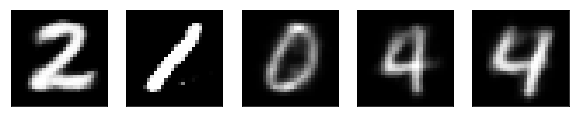

In [18]:
import torch.distributions as tdist

n = tdist.Normal(mean_sampled, std_sampled)

z_sampled =  n.sample((5,))
x_decoded = autoencoder.decode(z_sampled)

plot_digits(x_decoded)

## Zadanie 4. Interpolacja

Dla kilku przykładów ze zbioru trenującego zaimplementuj interpolacje pomiedzy parą punktów w przestrzeni _latent_, następnie zdekoduj te interpolacje i zwizualizuj wynik. Dla przypomnienie, liniowa interpolacja:

<br>

<font size=4>
$$ \forall \lambda \in [0,1] \quad f_L(x_1, x_2, \lambda) =  (1 - \lambda) x_1 + \lambda x_2 $$
</font>

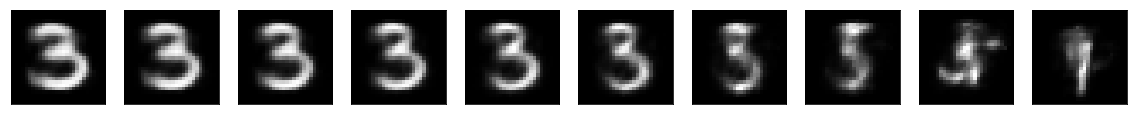

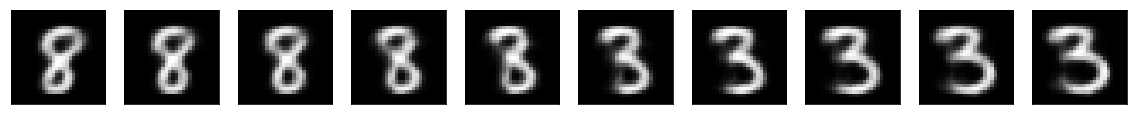

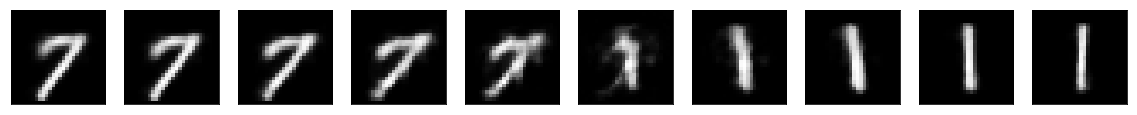

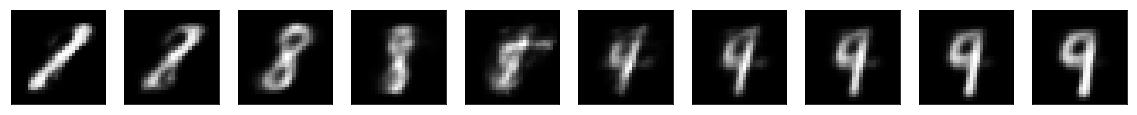

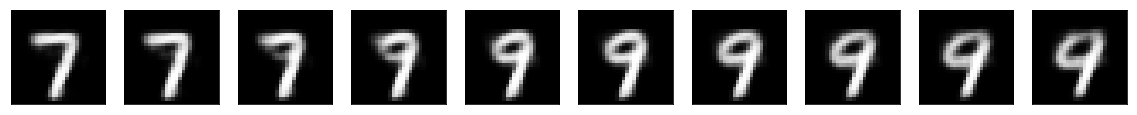

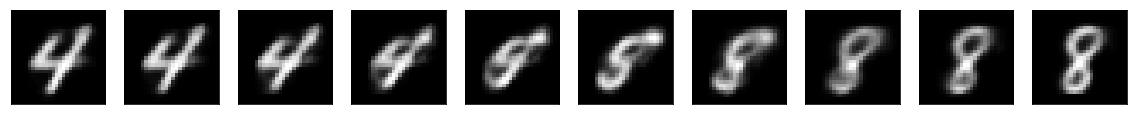

In [21]:
n_interpolations = 5

for step, (x, y) in enumerate(train_loader):
    if step > n_interpolations:
        break
    
    x_1 = x[0, :]
    x_2 = x[1, :]
    
    z_1 = autoencoder.encode(x_1)
    z_2 = autoencoder.encode(x_2)
    
    x_interpolated = []    
    for i, alpha in enumerate(np.linspace(0, 1, 10)):
        z_int = (1-alpha) * z_1 + alpha * z_2 # interpolate in the latent space
        x_int = autoencoder.decode(z_int) # decode the interpolated sample
        
        x_interpolated.append(x_int)
    
    x_interpolated = torch.stack(x_interpolated, dim=0)
    
    plot_digits(x_interpolated)
